*This notebook was created by Sergey Tomin (sergey.tomin@desy.de). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). January 2018.*

# Tutorial N2.  Tracking.

As an example, we will use lattice file (converted to Ocelot format) of the European XFEL Injector. 

##### This example will cover the following topics:
- calculation of the linear optics for the European XFEL Injector.
- Tracking of the particles in first and second order approximation without collective effects.

#### Coordiantes
Coordinates in Ocelot are following:
$$ \left (x, \quad x' = \frac{p_x}{p_0} \right), \qquad \left (y, \quad y' = \frac{p_y}{p_0} \right), \qquad \left (\tau = c\Delta t, \quad p = \frac{\Delta E}{p_0 c} \right)$$

Let's have a look on the new variable $\tau =  c t - \frac{s}{\beta_0}$. $s$ is independent variable which is the distance along the beam line (which, in turn, is the path length of the reference particle) and $v_0$ is the velocity of the reference particle, $t$ is the time at which a particle arrives at the position $s$ along the beam line. For the reference particle $\tau = 0$ for all $s$. A particle
arriving at a particular location at an earlier time than the reference particle has $\tau < 0$, and a particle arriving later than the reference particle has $\tau > 0$.

#### Requirements 
* injector_lattice.py - input file, the Injector lattice.
* beam_130MeV.ast    - input file, initial beam distribution in [ASTRA](http://www.desy.de/~mpyflo/) format.

In [1]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
%matplotlib inline

# this python library provides generic shallow (copy) and 
# deep copy (deepcopy) operations 
from copy import deepcopy

import time

# import from Ocelot main modules and functions
from ocelot import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

# import injector lattice
from injector_lattice import *

initializing ocelot...


If you want to see injector_lattice.py file you can run following command (lattice file is very large):
```
$ %load injector_lattice.py
```
The variable *cell* contains all the elements of the lattice in right order.

And again Ocelot will work with class MagneticLattice instead of simple sequence of element. So we have to run following command. 

In [2]:
lat = MagneticLattice(cell, stop=None)

## 1. Design optics calculation of the European XFEL Injector
#### *Remark*
*For convenience reasons, we define optical functions starting at the gun by backtracking of the optical functions derived from ASTRA (or similar space charge code) at 130 MeV at the entrance to the first quadrupole. The optical functions we thus obtain have obviously nothing to do with the actual beam envelope form the gun to the 130 MeV point.*

Because we work with linear accelerator we have to define initial energy and initial twiss paramters in order to get 
correct twiss functions along the Injector. 

In [3]:
# initialization of Twiss object
tws0 = Twiss()
# defining initial twiss parameters
tws0.beta_x = 29.171
tws0.beta_y = 29.171
tws0.alpha_x = 10.955
tws0.alpha_y = 10.955
# defining initial electron energy in GeV
tws0.E = 0.005 

# calculate optical functions with initial twiss parameters
tws = twiss(lat, tws0, nPoints=None)

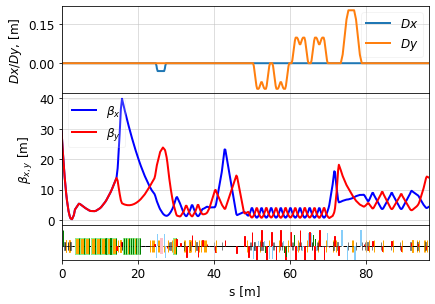

In [4]:
# ploting twiss paramentrs.
plot_opt_func(lat, tws, top_plot=["Dx", "Dy"], fig_name="i1", legend=False)
plt.show()

## 2. Tracking in first and second order approximation without any collective effects 

### Remark
*Because of the reasons mentioned above, we start the beam tracking from the first quadrupole after RF cavities.*

### Loading of beam distribution
In order to perform tracking we have to have beam distribution. We will load beam distribution from a ASTRA file ('beam_distrib.ast'). And we convert the Astra beam distribution to Ocelot format - ParticleArray. ParticleArray is designed for tracking.
In order to work with converters we have to import specific module from ocelot.adaptors
> from ocelot.adaptors.astra2ocelot import *

After importing **ocelot.adaptors.astra2ocelot** we can use converter astraBeam2particleArray() to load and convert.
As you will see beam distribution consists of 200 000 particles (**that is why loading can take a few second**), charge 250 pC, initial energy is about 6.5 MeV.

**ParticleArray** is a class which includes several parameters and methods. 
* ParticleArray.rparticles is a 2D numpy array (6 x N) with coordinates of particles in 
$$ParticleArray.rparticles = [\vec{x_0}, \vec{x_1}, ..., \vec{x_n}], $$ where $$\vec{x_n} = (x_n, x_n', y_n, y_n', \tau_n, p_n)^T$$
* ParticleArray.s is the longitudinal coordinate of the reference particle in [m]. 
* ParticleArray.E is the energy of the reference particle in [GeV]. 
* ParticleArray.q_array - is a 1D numpy array of the charges each (macro) particles in [C]

In [5]:
#from ocelot.adaptors.astra2ocelot import *
#p_array_init = astraBeam2particleArray(filename='beam_130MeV.ast')
#p_array_init = astraBeam2particleArray(filename='beam_130MeV_off_crest.ast')

# save ParticleArray to compresssed numpy array 
#save_particle_array("tracking_beam.npz", p_array_init)
p_array_init = load_particle_array("sc_beam.npz")

### Selection of the tracking order and lattice for the tracking.

MagneticLattice(sequence, start=None, stop=None, method=MethodTM()) have wollowing arguments:     
* sequence - list of the elements,
* start - first element of the lattice. If None, then lattice starts from the first element of the sequence,
* stop - last element of the lattice. If None, then lattice stops by the last element of the sequence,
* method=MethodTM() - method of the tracking. MethodTM() class assigns transfer map to every element. By default all elements are assigned first order transfer map - TransferMap. One can create one's own map, but there are following predefined maps:
    - TransferMap - first order matrices. 
    - SecondTM - 2nd order matrices.
    - KickTM - kick applyed.
    - RungeKuttaTM - Runge-Kutta integrator is applyed, but required 3D magnetic field function element.mag_field = lambda x, y, z: (Bx, By, Bz) (see example ocelot/demos/ebeam/tune_shift.py)

In [6]:
# initialization of tracking method
method = MethodTM()

# for second order tracking we have to choose SecondTM 
method.global_method = SecondTM

# for first order tracking uncomment next line
# method.global_method = TransferMap

# we start simulation from the first quadrupole (QI.46.I1) after RF section.
# you can change stop element (and the start element, as well) 
# START_73_I1 - marker before Dog leg
# START_96_I1 - marker before Bunch Compresion
lat_t = MagneticLattice(cell, start=start_sim, stop=None, method=method)

## Tracking

for tracking we have to define following objects:

- ```Navigator``` is object which navigates the beam distribution (ParticleArray) throught the lattice. The ```Navigator``` knows with what step (atr: ```unit_step```) the beam distribution will be tracked and knows where to apply one or another Physics Processes.   

In order to add collective effects (Space charge, CSR or wake) method ```add_physics_proc()``` must be called:
* ```add_physics_proc(physics_proc, elem1, elem2)```
    - physics_proc - physics process, can be CSR, SpaceCharge, Wake etc
    - elem1 and elem2 - first and last elements between which the physics process will be applied.
     
- ```attributes```:
    * ```unit_step = 1``` [m] (default value) - unit step for all physics processes 
        
<div class="alert alert-block alert-warning">
<b>Note:</b> unit_step is ignored if no PhysicsProcesses has been added (the PhysicsProc which applied as one kick is not counted, e.g. BeamTransform). In that case, the tracking is performed element by element. 
</div>

    
* ```track(lattice, p_array, navi, print_progress=True, calc_tws=True, bounds=None)``` 

the function performs tracking of the particles [```ParticleArray```] through the lattice [```MagneticLattice```]. This function also calculates twiss parameters of the beam distribution on each tracking step (optional). 

- ```lattice```: Magnetic Lattice
- ```p_array```: ParticleArray
- ```navi```: Navigator
- ```print_progress```: True, print tracking progress
- ```calc_tws```: True, during the tracking twiss parameters are calculated from the beam distribution
- ```bounds```: None, optional, [left_bound, right_bound] - bounds in units of std(p_array.tau()) to calculate twiss parameters of the particular beam slice. By default (```bounds=None```), twiss parameters are calculated for the whole beam.
    - return: twiss list, ParticleArray. In case calc_tws=False, twiss_list is list of empty Twiss classes.

In [7]:
navi = Navigator(lat_t)
p_array = deepcopy(p_array_init)
start = time.time()
tws_track, p_array = track(lat_t, p_array, navi)
print("\n time exec:", time.time() - start, "sec")

z = 0.3212 / 93.40410100084006 : applied: 

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

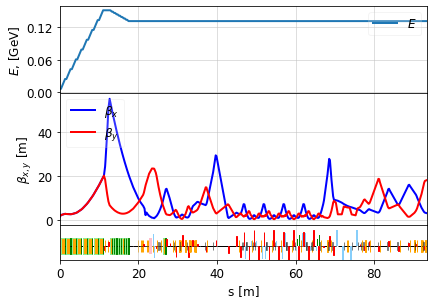

In [8]:
# you can change top_plot argument, for example top_plot=["alpha_x", "alpha_y"]
plot_opt_func(lat_t, tws_track, top_plot=["E"], fig_name=0, legend=False)
plt.show()

#### Tracking with beam matching

To match beam with design optics we can use artificial matching - beam Transformation:

**BeamTransform(tws=Twiss())**
In Twiss object beta, alpha functions as well as phase advances twiss.mux and twiss.muy (zero by default) also can be specified 

z = 93.40410100084 / 93.40410100084006 : applied: d:  mTransform
 time exec: 21.714136123657227 sec


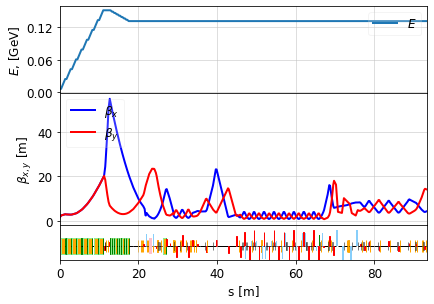

In [9]:
tw = Twiss()
tw.beta_x = 2.36088
tw.beta_y = 2.824
tw.alpha_x = 1.2206
tw.alpha_y = -1.35329

bt = BeamTransform(tws=tw)

navi = Navigator(lat_t)

navi.unit_step = 1 # ignored in that case, tracking will performs element by element. 
                   # - there is no PhysicsProc along the lattice, 
                   # BeamTransform is aplied only once

navi.add_physics_proc(bt, OTRC_55_I1, OTRC_55_I1)
p_array = deepcopy(p_array_init)
start = time.time()
tws_track, p_array = track(lat_t, p_array, navi)
print("\n time exec:", time.time() - start, "sec")
plot_opt_func(lat_t, tws_track, top_plot=["E"], fig_name=0, legend=False)
plt.show()

<div class="alert alert-block alert-warning">
<b>Note:</b> The function “track()” reruns twiss list ("tws_track") and ParticleArray ("p_array").  “p_array” is final ParticleArray. "tws_track” is a list of Twiss objects where twiss parameters are calculated from the particle distribution. So, inside each Twiss object, there are twiss parameters (beta_x, alpha_x, beta_y, alpha_y) and emittances (emit_x, emit_y) as well as the first and second moments, e.g. $x\cdot x$, $x\cdot px$, $px \cdot px$, $x \cdot y$, $y \cdot px$ and so on. It can be useful, if you want to see evolution of the beam during tracking with collective effects.
</div>

Here are examples how to retrieve the beam parameters from the twiss list.
To retrieve the trajectory of the beam (central of mass):
> x = [tw.x for tw in tws_track]

Or size:

> sigma_x = np.sqrt([tw.xx for tw in tws_track])

Where tw.xx is the second moment. 
Also, you can retrieve the beam length during beam tracking 

> sigma_tau = np.sqrt([tw.tautau for tw in tws_track])

And you need the longitudinal coordinate along the lattice:
> s = [tw.s for tw in tws_track]

### Example 

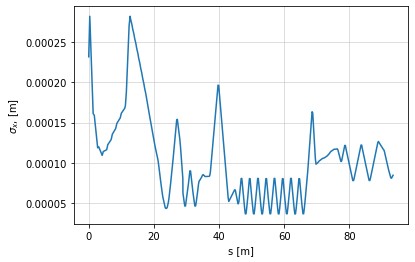

In [10]:
sigma_x = np.sqrt([tw.xx for tw in tws_track])
s = [tw.s for tw in tws_track]

plt.plot(s, sigma_x)
plt.xlabel("s [m]")
plt.ylabel(r"$\sigma_x$, [m]")
plt.show()


#### Beam distribution

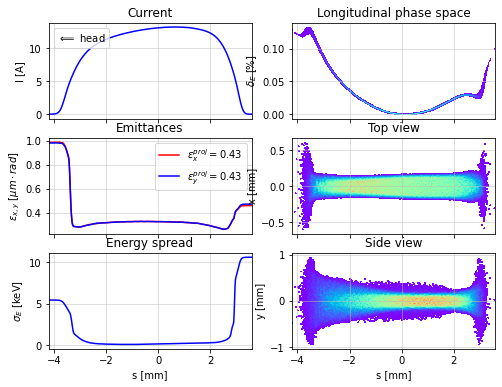

In [11]:
# the beam head is on left side 
show_e_beam(p_array, figsize=(8,6))

### Explicit usage of matplotlib functions
#### Current profile

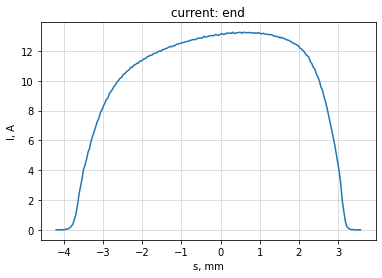

In [12]:
bins_start, hist_start = get_current(p_array, num_bins=200)

plt.figure(4)
plt.title("current: end")
plt.plot(bins_start*1000, hist_start)
plt.xlabel("s, mm")
plt.ylabel("I, A")
plt.grid(True)
plt.show()

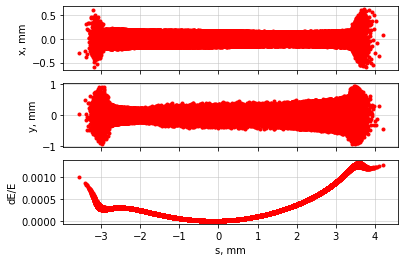

In [13]:
tau = np.array([p.tau for p in p_array])
dp = np.array([p.p for p in p_array])
x = np.array([p.x for p in p_array])
y = np.array([p.y for p in p_array])

ax1 = plt.subplot(311)
# inverse head and teil. The beam head is right side
ax1.plot(-tau*1000, x*1000, 'r.')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel("x, mm")
plt.grid(True)

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(-tau*1000, y*1000, 'r.')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel("y, mm")
plt.grid(True)

ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(-tau*1000, dp, 'r.')
plt.ylabel("dE/E")
plt.xlabel("s, mm")
plt.grid(True)
plt.show()